**Notebook run in https://colab.research.google.com/ **


# Session in notebook aims to generate model for RNA Guadruplexes sequences using the CNN(Covolutional Neural Network) architecture

# **General Python Modules**





In [ ]:

import io
import sys
import math
import random
import pandas as pd
import glob, os
import numpy as np
from tensorflow import keras as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib.pyplot import figure


# **Training datasets contain equal number of positives and negatives sequences**

In [ ]:

# Path to the directory 
base_path = ''
train_negative_path = base_path+ 'KPDS_1_1_train_negative.tsv'
train_positive_path = base_path+ 'KPDS_1_1_train_positive.tsv'
file_type='KPDS'

# Reading the file
train_negative = pd.read_csv(train_negative_path, sep='\t', header=None)
train_positive = pd.read_csv(train_positive_path, sep='\t', header=None)

# add labels
train_negative["label"] = "negative"
train_positive["label"] = "positive"

#Combining Positive and Negative datasets
binding_table = train_negative.append(train_positive)
binding_table.to_csv('train_set_{file_type}_1_1'+ '.txt', sep='\t', index=False, header=False)
print(binding_table)


                                                      0     label
0     gcgattcttctgcctcagcctcccaaatagctgggattacaggcgc...  negative
1     GGAGCCCCACTAGCCTGTGCCCGGGCATGGCCTGGCAGCTCTCCAG...  negative
2     gtaataattcccaagctggacatacataaatccaatcctattagtg...  negative
3     CAGCTCAGCCCTGTACATATACCTGTCCCTCTCTGGCTTGGTCCCC...  negative
4     gtgcatatgtgaagcccagaaatgcagggcagtgaaagccctcaca...  negative
...                                                 ...       ...
9243  TACATTAAAAGCCTGTTAGCATTCTCTAAAGCCTTTTTGTTTTCTC...  positive
9244  cccagggtaaaacgcaagaaatcaaagatttggggataaaataaag...  positive
9245  cagctacttcggaggttaaggcacgagaagtgcttgaacccaaggg...  positive
9246  CTGTGGCCGGCCAGCATGAGCCAttaggatggagttgagctgcgag...  positive
9247  CGAGATGAGCCCCCCCAGCGTCAAGATTAAGGGGAGAGCTTAAGGA...  positive

[18496 rows x 2 columns]


# **Model architecture**

In [ ]:

def create_architecture(
        sequence_size=200,
        channel=4
):
    """
  fun create the model based on sequence input
  size.

  parameters:
  sequence_size = length of the sequence in nt
  channel = each channel corresponds to a nucleotide.
  """
    model = K.models.Sequential()

    model.add(K.layers.Conv1D(
        filters=16,
        kernel_size=8,
        padding='same',
        data_format="channels_last",
        activation='relu',
        input_shape=(sequence_size, channel)))

    model.add(K.layers.BatchNormalization())
    model.add(K.layers.MaxPooling1D())
    model.add(K.layers.Dropout(0.3))

    model.add(K.layers.Conv1D(
        filters=8,
        kernel_size=8,
        padding='same',
        data_format="channels_last",
        activation='relu'))

    model.add(K.layers.BatchNormalization())
    model.add(K.layers.MaxPooling1D())
    model.add(K.layers.Dropout(0.3))

    model.add(K.layers.Conv1D(
        filters=4,
        kernel_size=8,
        padding='same',
        data_format="channels_last",
        activation='relu'))

    model.add(K.layers.BatchNormalization())
    model.add(K.layers.MaxPooling1D())
    model.add(K.layers.Dropout(0.3))

    model.add(K.layers.Conv1D(
        filters=3,
        kernel_size=8,
        padding='same',
        data_format="channels_last",
        activation='relu'))

    model.add(K.layers.BatchNormalization())
    model.add(K.layers.MaxPooling1D())
    model.add(K.layers.Dropout(0.3))

    model.add(K.layers.Flatten())

    model.add(K.layers.Dense(512, activation="relu"))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dropout(0.2))

    model.add(K.layers.Dense(1, activation='sigmoid'))

    model.summary()
    return model


def compile_network(model):
    optimizer = K.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def compile_network(model):
    optimizer = K.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# **Building the one hot encoding numpy array of each sample sequence**

In [ ]:

def sequence_to_ohe(
        dataset,
        sequence_size=200,
        channel={
            'A': 0,
            'T': 1,
            'C': 2,
            'G': 3,
            'a': 0,
            't': 1,
            'c': 2,
            'g': 3
        }
):
    """
  fun builds the one hot encoding numpy array of each
  sample sequence.

  paramenters:
  sequence_size = can corresponds to the
  length of the input sequences
  (if all the same) or an arbitrary number can be defined.
  channel = the coding of nucleotides.

  """

    samples_size = len(dataset)
    ohe_dataset = np.zeros((samples_size, sequence_size, len(set(channel.values()))))

    for index, sequence in enumerate(dataset):
        for pos, nucleotide in enumerate(sequence):
            if nucleotide == 'N':
                continue
            ohe_dataset[index, pos, channel[nucleotide]] = 1

    return ohe_dataset




# **Loading training datasets and performing train test split**

In [ ]:
filename_train= base_path+ 'train_set_{file_type}_1_1.txt'
def load_dataset_train(filename_train):
    """
    fun loads dataset from 'filename' and prepares it for training
    It separates pseudo-randomly third of the set,
    that can be saved for later evaluation of the model
    :return four sets, X means sequences, y labels

    """

    df = pd.read_csv(filename_train, sep='\t', names=['sequence', 'label'])

    sequence_df = sequence_to_ohe(
        dataset=df['sequence'].tolist(),
        sequence_size=200,
    )

    labels_df = np.array(list(map((lambda x: 1 if x == 'positive' else 0), list(df['label']))))

    if sequence_df.shape[0] == labels_df.shape[0]:
        print('dataset OK')
    else:
        print('sequence and label shapes are different, something went wrong...')

    print(
        'sequence_df samples',
        sequence_df.shape,
        'labels_df samples',
        labels_df.shape,
        sep='\t'
    )

    X_train, X_test, y_train, y_test = train_test_split(
        sequence_df, labels_df, test_size=0.33, random_state=1989)

    print(
        'X_train sequences',
        X_train.shape[0],
        'y_train labels',
        y_train.shape[0],
        sep='\t'
    )

    print(
        'X_test sequences',
        X_test.shape[0],
        'y_test labels',
        y_test.shape[0],
        sep='\t'
    )

    return X_train, X_test, y_train, y_test




# **Plotting the parameters, Precision-recall curve**

dataset OK
sequence_df samples	(18496, 200, 4)	labels_df samples	(18496,)
X_train sequences	12392	y_train labels	12392
X_test sequences	6104	y_test labels	6104
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 200, 16)           528       
                                                                 
 batch_normalization_5 (Batc  (None, 200, 16)          64        
 hNormalization)                                                 
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 100, 16)          0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 100, 16)           0         
                                                                 
 conv1d_5 (Conv1D)        

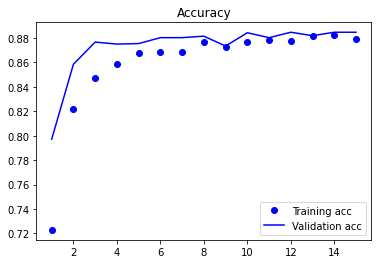

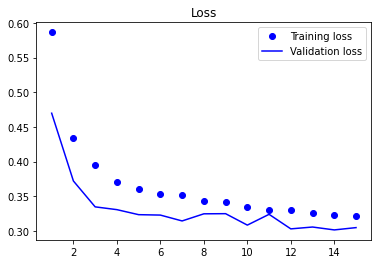

model evaluation on unknown dataset [loss, accuracy]: [0.28551727533340454, 0.8976081013679504]


In [ ]:
def draw_precision_recall_curve(model, sequences, labels):
    probs = model.predict(sequences)
    precision, recall, thresholds = precision_recall_curve(labels, probs)
    plt.plot(recall, precision, marker='.', label='My model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower center")
    plt.title('Precision recall curve')
    plt.show()


def ROC_curve(probs, labels):
    fpr, tpr, thresholds = roc_curve(labels, probs)
    auc_score = roc_auc_score(labels, probs)
    print("AUC score: ", auc_score)
    figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(fpr, tpr, 'blue', label='My model')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower center")
    plt.title('ROC curve')
    plt.show()


def plot_history(history):
    """
    fun plots history of the training of the model,
    accuracy and loss of the training and validation set

    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()


def main():
    X_train, X_test, y_train, y_test = load_dataset_train(f'/content/train_set_{filetype}_1_1.txt')
    model = create_architecture(sequence_size=200, channel=4)
    model = compile_network(model=model)

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=15,
        validation_split=0.2
    )

    plot_history(history)

    metrics = model.evaluate(
        X_test,
        y_test,
        verbose=0
    )

    print('model evaluation on unknown dataset [loss, accuracy]:', metrics)
    (model, X_test, y_test)

    model.save('model_{filetype}_1_1.h5')


main()

# **Loading test datasets and test split**

In [ ]:
base_path = ''
test_negative_path = base_path+ 'KPDS_1_1_test_negative.tsv'
test_positive_path = base_path+ 'KPDS_1_1_test_positive.tsv'
file_type='KPDS'


test_negative = pd.read_csv(test_negative_path, sep='\t', header=None)
test_positive = pd.read_csv(test_positive_path, sep='\t', header=None)

# add labels
test_negative["label"] = "negative"
test_positive["label"] = "positive"

binding_table_test= test_negative.append(test_positive)
binding_table_test.to_csv('test_set_{file_type}_1_1' + '.txt', sep='\t', index=False, header=False)


filename_test= base_path+ 'test_set_{filetype}_1_1.txt'
def load_dataset_test(filename_test):
    """
    fun loads dataset from 'filename' and prepares it for test
    :return four sets, X means sequences, y labels

    """

    df = pd.read_csv(filename_test, sep='\t', names=['sequence', 'label'])

    sequence_df = sequence_to_ohe(
        dataset=df['sequence'].tolist(),
        sequence_size=200,
    )

    labels_df = np.array(list(map((lambda x: 1 if x == 'positive' else 0), list(df['label']))))

    X_eval=sequence_df 
    y_eval=labels_df


    if sequence_df.shape[0] == labels_df.shape[0]:
        print('dataset OK')
    else:
        print('sequence and label shapes are different, something went wrong...')

    print(
        'sequence_df samples',
        sequence_df.shape,
        'labels_df samples',
        labels_df.shape,
        sep='\t'
    )


    print(
        'X_eval sequences',
        X_eval.shape[0],
        'y_test labels',
        y_eval.shape[0],
        sep='\t'
    )

    return X_eval, y_eval



# **Validation of testset and precision recall curve**

dataset OK
sequence_df samples	(5000, 200, 4)	labels_df samples	(5000,)
X_eval sequences	5000	y_test labels	5000
model evaluation on matric dataset [loss, accuracy]: [0.21604794263839722, 0.9351999759674072]


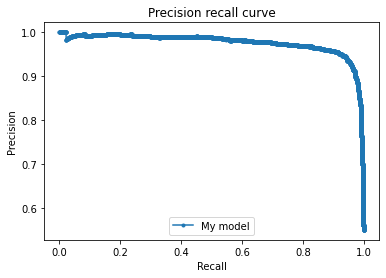

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

def main():
  X_eval,y_eval= load_dataset_test('/content/test_set_{file_type}_1_1.txt')
  test = K.models.load_model('model_{file_type}_1_1.h5')
  met = test.evaluate(
        X_eval,
        y_eval,
        verbose=0
        )
  print('model evaluation on matric dataset [loss, accuracy]:', met)
  draw_precision_recall_curve(test,X_eval, y_eval)

main()